In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
test_ratio = 0.1
data_range = 3
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1

In [6]:
def pow_fun(x):
    return np.power(x, 3)


In [7]:
data_x = np.arange(-data_range, data_range + data_step, data_step)
data_x = np.reshape(data_x, [data_x.shape[0], 1])
data_y = np.zeros([data_x.shape[0], 1])
data_y_true = np.zeros([data_x.shape[0], 1])

In [17]:
for i in range(data_x.shape[0]):
    if (data_x[i,0] < 0): 
        data_y[i, 0] = pow_fun(data_x[i,0]) + np.random.normal(0, data_sigma1)
    else:
        data_y[i, 0] = pow_fun(data_x[i,0]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i, 0] = pow_fun(data_x[i,0])

In [18]:
data_y

array([[-27.29457914],
       [-23.45914486],
       [-29.85999676],
       ...,
       [ 26.13092274],
       [ 27.04806237],
       [ 28.34745347]])

In [19]:
num_train_data = int(data_x.shape[0] * (1 - test_ratio))
num_test_data  = data_x.shape[0] - num_train_data
train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

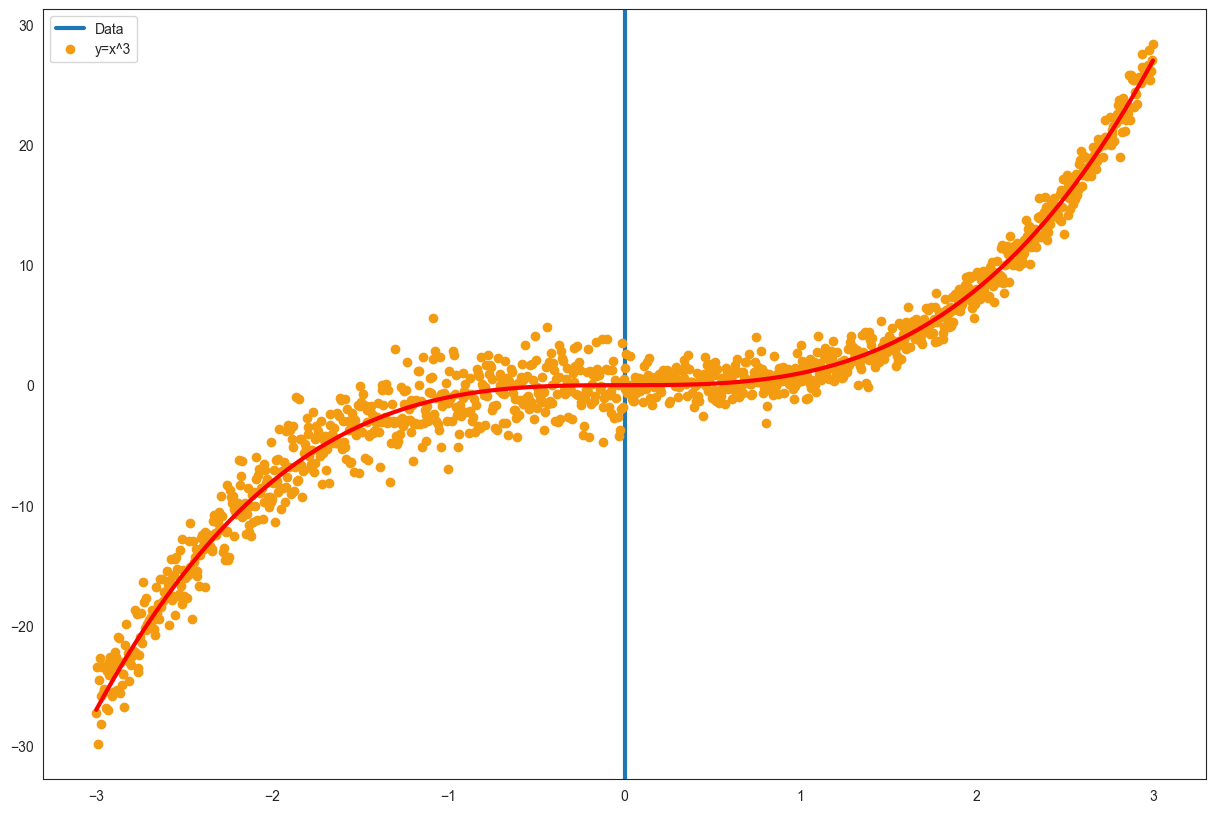

In [20]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.axvline(x=0, linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
# plt.title('y = x^3 where $\epsilon$ ~ N(0, 3^2) and N(0, 1^2)')
plt.show()

In [23]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout
from keras.models import Model
from keras.initializers import glorot_normal
import numpy as np


2023-11-16 02:18:09.712508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import backend as K

def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5 * tf.math.log(sigma) + 0.5 * tf.divide(tf.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss

class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1',
                                        shape=(input_shape[1], self.output_dim),
                                        initializer=GlorotNormal(),
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2',
                                        shape=(input_shape[1], self.output_dim),
                                        initializer=GlorotNormal(),
                                        trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                      shape=(self.output_dim,),
                                      initializer=GlorotNormal(),
                                      trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                      shape=(self.output_dim,),
                                      initializer=GlorotNormal(),
                                      trainable=True)
        super(GaussianLayer, self).build(input_shape)

    def call(self, x):
        output_mu = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06
        return [output_mu, output_sig_pos]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]


In [33]:
inputs = Input(shape=(1,))
x = Dense(10, activation='relu')(inputs)
x = Dense(6, activation='relu')(x)
x = Dense(30, activation='relu')(x)
mu, sigma = GaussianLayer(1, name='main_output')(x)
model = Model(inputs, mu)
model.compile(loss=custom_loss(sigma), optimizer='adam')
model.fit(train_x, train_y, epochs=400)

Epoch 1/400


TypeError: in user code:

    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 329, in __call__
        self._total_loss_mean.update_state(
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 509, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/Users/amirasrzad/anaconda3/envs/isr/lib/python3.11/site-packages/keras/src/engine/keras_tensor.py", line 285, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_5'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
